In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import time

## global constants

In [2]:
# use gpu
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)
bohr_radius = 0.529  # angstroms, constant used globally throughout this nb

cuda


## data generation functions

In [3]:
def gen_spherical_data(N, min_r, max_r, device):
    """
    Returns tensor of shape (N, 3) where each row is 
    r (angstroms), theta (radians), phi (radians)
    """ 
    
    min_angle = 0.
    max_angle = 2. * np.pi  # using [0, 2pi] as range for theta and phi, convention is +-[0, pi] for theta usually
    
    r_vals = np.random.uniform(low=min_r, high=max_r, size=(N, 1))
    theta_vals = np.random.uniform(low=min_angle, high=max_angle, size=(N, 1))
    phi_vals = np.random.uniform(low=min_angle, high=max_angle, size=(N, 1))
    combined = np.concatenate([r_vals, theta_vals, phi_vals], axis=1)
    np.random.shuffle(combined)  # this may not be necessary since data is uniform random 
    data = torch.tensor(combined, requires_grad=True).to(device)
    
    return data

def spherical_to_cartesian(spherical_data):
    """
    Given tensor of spherical data of shape (N, 3) where each row is 
    r, theta, phi, convert to cartesian x, y, z and return tensor of shape (N, 3)
    where each row is x, y, z 
    """
    
    x = (spherical_data[:, 0] * torch.sin(spherical_data[:, 1]) * torch.cos(spherical_data[:, 2])).reshape(-1, 1)
    y = (spherical_data[:, 0] * torch.sin(spherical_data[:, 1]) * torch.sin(spherical_data[:, 2])).reshape(-1, 1)
    z = (spherical_data[:, 0] * torch.cos(spherical_data[:, 1])).reshape(-1, 1)
    cartesian_data = torch.cat([x, y, z], dim=1)
    
    return cartesian_data

def batch_data(data, num_batches):
    """
    data: tensor with shape (n, m)
    num_batches: number of batches to split data into
    
    Returns a tensor with shape (num_batches, n // num_batches, m) and assumes n is divisible by num_batches
    """
    return data.reshape(num_batches, data.shape[0] // num_batches, data.shape[1])

## define PINNs

In [4]:
class RadialPINN(nn.Module):
    """
    Radial equation R(r) PINN
    """
    
    def __init__(self, input_size, l, planck_term_constant, charge_term_constant, device):
        super(RadialPINN, self).__init__()
        self.device = device
        self.l = l  # angular quantum number
        self.radial_eqn_rhs = self.l * (self.l + 1)
        self.radial_planck_term_constant = 1 / planck_term_constant  # 2*m/hbar**2 in units eV^-2*s^-2*kg
        self.charge_term_constant = charge_term_constant
        
        # E layer
        self.E = None
        self.E_ones_len = 1
        self.E_ones = torch.ones(self.E_ones_len, dtype=torch.double).to(self.device)
        self.E_layer = nn.Linear(self.E_ones_len, 1, dtype=torch.double)
        
        # E < 0 by definition (electron is bound to atom), suggest this direction initially
        self.E_layer.weight.data.fill_(-0.1)
        self.E_layer.bias.data.fill_(-0.1)
        
        # network
        self.tanh = nn.Tanh() 
        self.dense0 = nn.Linear(input_size, 50, dtype=torch.double)  # NOTE input_size must account for internal E value too 
        self.dense1 = nn.Linear(50, 50, dtype=torch.double) 
        self.dense2 = nn.Linear(50, 50, dtype=torch.double)
        self.dense3 = nn.Linear(50, 1, dtype=torch.double)
    
    def forward(self, r):
        # predict E
        self.E = self.E_layer(self.E_ones)
        E_batch = torch.tensor([[self.E[0]]] * r.shape[0]).to(device)
        
        # combine E with r
        nn_inp = torch.cat([r, E_batch], dim=1)
        
        # pass through network
        out = self.dense0(nn_inp)
        out = self.tanh(out)
        out = self.dense1(out)
        out = self.tanh(out)
        out = self.dense2(out)
        out = self.tanh(out)
        R = self.dense3(out)
        
        return R

    def calc_loss_de(self, r, R):
        """
        Radial eqn. loss. Split into multiple lines for clarity.
        """
        
        # dR/dr
        R_r = torch.autograd.grad(R, r, grad_outputs=torch.ones_like(R), retain_graph=True, create_graph=True)[0]
        
        # calculate loss
        term0 = r**2 * R_r
        term1 = (1 / R) * torch.autograd.grad(term0, r, grad_outputs=torch.ones_like(term0), retain_graph=True, create_graph=True)[0]
        term2 = self.radial_planck_term_constant * r**2 * (self.charge_term_constant / r - self.E)
        term3 = term1 - term2 - self.radial_eqn_rhs
        loss_de = torch.mean(term3**2)
        
        return loss_de

In [5]:
class AngularPINN(nn.Module):
    """
    Angular equation Y(θ, ϕ) PINN
    """
    
    def __init__(self, input_size, l):
        super(AngularPINN, self).__init__()
        self.l = l  # angular quantum number
        self.angular_eqn_rhs = -self.l * (self.l + 1)
        
        # network
        self.tanh = nn.Tanh() 
        self.dense0 = nn.Linear(input_size, 50, dtype=torch.double)  # NOTE input_size must account for internal E value too 
        self.dense1 = nn.Linear(50, 50, dtype=torch.double) 
        self.dense2 = nn.Linear(50, 50, dtype=torch.double)
        self.dense3 = nn.Linear(50, 1, dtype=torch.double)
    
    def forward(self, theta, phi):
        # concat angles to input to nn
        # theta and phi are initially kept separate in order to calculate gradients later
        angles = torch.cat([theta, phi], dim=1)
        
        # pass through network
        out = self.dense0(angles)
        out = self.tanh(out)
        out = self.dense1(out)
        out = self.tanh(out)
        out = self.dense2(out)
        out = self.tanh(out)
        Y = self.dense3(out)
        
        return Y
    
    def calc_loss_de(self, theta, phi, Y):
        """
        Angular eqn. loss. Split into multiple lines for clarity.
        """
        
        # dY/dθ
        Y_theta = torch.autograd.grad(Y, theta, grad_outputs=torch.ones_like(Y), retain_graph=True, create_graph=True)[0]
        
        # dY/dϕ
        Y_phi = torch.autograd.grad(Y, phi, grad_outputs=torch.ones_like(Y), retain_graph=True, create_graph=True)[0]
        
        # d^2Y/dϕ^2
        Y_phiphi = torch.autograd.grad(Y_phi, phi, grad_outputs=torch.ones_like(Y_phi), retain_graph=True, create_graph=True)[0]
        
        # calculate loss
        term0 = torch.sin(theta) * Y_theta 
        term1 = (1 / torch.sin(theta)) * torch.autograd.grad(term0, theta, grad_outputs=torch.ones_like(term0), retain_graph=True, create_graph=True)[0]
        term2 = (1 / torch.sin(theta**2)) * Y_phiphi
        term3 = (1 / Y) * (term1 + term2) - self.angular_eqn_rhs
        loss_de = torch.mean(term3**2)
        
        return loss_de

In [6]:
class HydrogenPsiPINN(nn.Module):
    """
    Hydrogen wave function ψ(r, θ, ϕ) PINN
    """
    
    def __init__(self, input_size, l, device, optimizer_lr=0.0001):
        super(HydrogenPsiPINN, self).__init__()
        self.device = device
        
        # constants
        self.l = l  # angular quantum number
        self.planck_term_constant = 0.2378  # hbar**2/2*m in units eV^2*s^2*kg^-1
        self.charge_term_constant = 230.7078  # e^2/4*pi*epsilon_0 in units s^-2*kg*angstroms^3
        
        # sub-PINNs
        self.R_PINN = RadialPINN(2, l, self.planck_term_constant, self.charge_term_constant, device)
        self.Y_PINN = AngularPINN(2, l)
        
        # loss + optimizer
        self.ovr_loss = None
        self.optimizer = optim.Adam(self.parameters(), lr=optimizer_lr, betas=(0.9, 0.98), eps=1e-9)
    
    def forward(self, r, theta, phi):
        # pass data through radial and angular networks
        R = self.R_PINN.forward(r)
        Y = self.Y_PINN.forward(theta, phi)
        
        # calculate wave function
        psi = R * Y
        
        return psi, R, Y
    
    def calc_loss_de(self, r, theta, phi, psi):
        """
        Spherical schrodinger eqn. loss
        I broke this down into mutliple lines just for reading clarity (could be 1 line)
        """
        
        # dψ/dr
        psi_r = torch.autograd.grad(psi, r, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]
        
        # dψ/dθ
        psi_theta = torch.autograd.grad(psi, theta, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]
        
        # dψ/dϕ
        psi_phi = torch.autograd.grad(psi, phi, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]
        
        # d^2ψ/dϕ^2
        psi_phiphi = torch.autograd.grad(psi_phi, phi, grad_outputs=torch.ones_like(psi_phi), retain_graph=True, create_graph=True)[0]
        
        # calculate loss
        term0 = r**2 * psi_r
        term1 = (1 / r**2) * torch.autograd.grad(term0, r, grad_outputs=torch.ones_like(term0), retain_graph=True, create_graph=True)[0] 
        term2 = torch.sin(theta) * psi_theta
        term3 = (1 / (r**2 * torch.sin(theta))) * torch.autograd.grad(term2, theta, grad_outputs=torch.ones_like(term2), retain_graph=True, create_graph=True)[0] 
        term4 = (1 / (r**2 * torch.sin(theta**2))) * psi_phiphi
        term5 = -self.planck_term_constant * (term1 + term3 + term4)
        term6 = term5 - (self.charge_term_constant) * (1 / r) - self.R_PINN.E * psi
        loss_de = torch.mean(term6**2)
        
        return loss_de
    
    def calc_loss_norm(self, psi):
        """
        Normalized wave function loss
        """
        return torch.dot(psi.flatten(), psi.flatten()) - 1
    
    def calc_ovr_loss(self, r, theta, phi, psi, R, Y, test_pass=False):
        # calculate wave function loss 
        psi_loss_de = self.calc_loss_de(r, theta, phi, psi)
        
        # calculate normalized wave function loss
        psi_loss_norm = self.calc_loss_norm(psi)
        
        # total loss term
        ovr_loss = psi_loss_norm + psi_loss_de 
        
        # loss value used for backprop during training
        if not test_pass:
            self.ovr_loss = ovr_loss
        
        return ovr_loss, psi_loss_norm, psi_loss_de
    
    def backward(self):
        # backprop + update params
        self.optimizer.zero_grad()
        self.ovr_loss.backward()
        self.optimizer.step()

## analytical solution functions

In [7]:
def calc_radial_prob_density(spherical_data, R_10_vals):
    """
    Calculates the radial probability density using R_10(r).
    See http://hyperphysics.phy-astr.gsu.edu/hbase/quantum/hydr.html (they divide result
    by bohr radius)
    
    inputs:
    spherical_data: numpy array of spherical data with shape (N, 3)
    R_10_vals: numpy array of radial function values with shape (N,)
    """
    
    return 4 * np.pi * spherical_data[:, 0]**2 * R_10_vals**2


def calc_psi_prob_density(spherical_data, psi_100_vals):
    """
    Calculates the probability density of psi_100. 
    
    inputs:
    spherical_data: numpy array of spherical data with shape (N, 3)
    psi_100: numpy array of 1s^1 wave function values with shape (N,)
    """
    
    return 4 * np.pi * spherical_data[:, 0]**2 * psi_100_vals**2

In [8]:
def calc_full_psi_100(spherical_data):
    """
    Calculate analytical 1s^1 H wave function for spherical data (doesn't use R or Y 
    explicitly).
    
    inputs:
    spherical_data: numpy array of spherical data with shape (N, 3)
    """
    
    return ((1 / np.sqrt(np.pi * bohr_radius**3)) * np.exp(-spherical_data[:, 0] / bohr_radius))


def calc_R_10(spherical_data):
    """
    Calculate R_10(r) for H. Only uses r data column in spherical_data
    
    inputs:
    spherical_data: numpy array of spherical data with shape (N, 3)
    """
    
    return 2 * bohr_radius**(-1.5) * np.exp(-spherical_data[:, 0] / bohr_radius)


def calc_Y_00(spherical_data):
    """
    Calculate Y_00(theta, phi) for H. This is just a constant, but it returns an array
    of shape (N,) (doing this is a bit of a formality, but for psi other than ground state, 
    this will actually depend on theta and phi values)
    
    inputs:
    spherical_data: numpy array of spherical data with shape (N, 3)
    """
    
    return np.array([np.sqrt((1 / (4 * np.pi)))] * spherical_data.shape[0])


def calc_psi_100(R_10_vals, Y_00_vals):
    """
    Calculate 1s^1 H wave function using R_10(r) and Y_00(theta, phi). This returns
    the same result as calc_full_psi_100 if same inputs used.
    
    inputs:
    R_10_vals: numpy array of radial function values with shape (N,)
    Y_00_vals: numpy array of angular function values with shape (N,)
    """
    
    return R_10_vals * Y_00_vals


def calc_E(n):
    """
    For given quantum number n, returns energy level in eV
    
    inputs:
    n: quantum number n
    """
    
    return -13.6 / n**2

## generate data

In [9]:
N = 10000
train_N = int(0.8 * N)
min_r = 0.1  # angstroms
max_r = 6.  # angstroms

# generate data
spherical_data = gen_spherical_data(N, min_r, max_r, device)
train_data = spherical_data[:train_N]
test_data = spherical_data[train_N:]

# split train data into r, theta, phi batches
# inputs must be split for gradient calcs later
train_r_batches = batch_data(train_data[:, 0].reshape(-1, 1), 10)
train_theta_batches = batch_data(train_data[:, 1].reshape(-1, 1), 10)
train_phi_batches = batch_data(train_data[:, 2].reshape(-1, 1), 10)

# split test data into r, theta, phi
test_r = test_data[:, 0].reshape(-1, 1)
test_theta = test_data[:, 1].reshape(-1, 1)
test_phi = test_data[:, 2].reshape(-1, 1)

## main train loop

In [10]:
l = 0  # angular quantum number
psi_PINN = HydrogenPsiPINN(train_data.shape[1] + 1, l, device).to(device)  # initialize PINN
num_epochs = 10000
mean_train_loss_vals = []
mean_test_loss_vals = []
E_predictions = []
total_time = 0
loss_names = ["ovr_loss", "psi_loss_norm", "psi_loss_de"]

# MAIN TRAIN LOOP
for epoch in range(num_epochs):
    print("\n" + "=" * 20 + f" EPOCH {epoch} " + "=" * 20)
    epoch_start = time.time()
    train_loss_vals = []
    
    for i, (train_r, train_theta, train_phi) in enumerate(zip(train_r_batches, train_theta_batches, train_phi_batches)):
        # forward pass
        psi, R, Y = psi_PINN.forward(train_r, train_theta, train_phi)
        
        # calculate loss + backprop
        train_losses = psi_PINN.calc_ovr_loss(train_r, train_theta, train_phi, psi, R, Y)
        train_loss_vals.append(train_losses)
        
        # backprop + update network
        psi_PINN.backward()
        
    # mean train loss
    mean_train_loss_vals.append(torch.mean(torch.tensor(train_loss_vals), axis=0).detach().numpy())
    
    # output train losses
    print("train:")
    for loss_name_idx in range(len(train_losses)):
        print(f"{loss_names[loss_name_idx]}: {mean_train_loss_vals[epoch][loss_name_idx]}")
    
    # test pass
    test_psi, test_R, test_Y = psi_PINN.forward(test_r, test_theta, test_phi)
    test_losses = psi_PINN.calc_ovr_loss(test_r, test_theta, test_phi, test_psi, test_R, test_Y)
    mean_test_loss_vals.append([loss.item() for loss in test_losses])
    
    # output test losses
    print()
    print("test:")
    for loss_name_idx in range(len(train_losses)):
        print(f"{loss_names[loss_name_idx]}: {mean_test_loss_vals[epoch][loss_name_idx]}")
    
    print()
    print(f"E_n = {psi_PINN.R_PINN.E.item()}")
    print()
    epoch_time = (time.time() - epoch_start) / 60
    total_time += epoch_time
    print(f"epoch time: {epoch_time:.2f} minutes")
    print(f"total time elapsed: {total_time:.2f} minutes")
    E_predictions.append(psi_PINN.R_PINN.E.item())
    
mean_train_loss_vals = np.array(mean_train_loss_vals)
mean_test_loss_vals = np.array(mean_test_loss_vals)


==================== EPOCH 0 ====================
train:
ovr_loss: 265161.05773285
psi_loss_norm: -0.6411494171422747
psi_loss_de: 265161.6988822672

test:
ovr_loss: 77713.59230434652
psi_loss_norm: -0.32463755732181787
psi_loss_de: 77713.91694190384

E_n = -0.19805913776736686

epoch time: 0.00 minutes
total time elapsed: 0.00 minutes

==================== EPOCH 1 ====================
train:
ovr_loss: 145000.07416880465
psi_loss_norm: -0.7764044934543798
psi_loss_de: 145000.8505732981

test:
ovr_loss: 77674.13754567948
psi_loss_norm: -0.5455429088468062
psi_loss_de: 77674.68308858832

E_n = -0.19623900994023544

epoch time: 0.00 minutes
total time elapsed: 0.01 minutes

==================== EPOCH 2 ====================
train:
ovr_loss: 105992.41845083034
psi_loss_norm: -0.8433967149715274
psi_loss_de: 105993.26184754532

test:
ovr_loss: 77651.1621176727
psi_loss_norm: -0.6619387258115434
psi_loss_de: 77651.82405639852

E_n = -0.19458248598209466

epoch time: 0.00 minutes
total time e

## loss plots

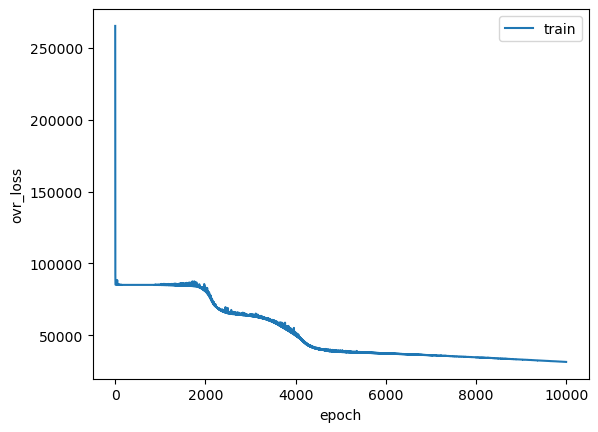

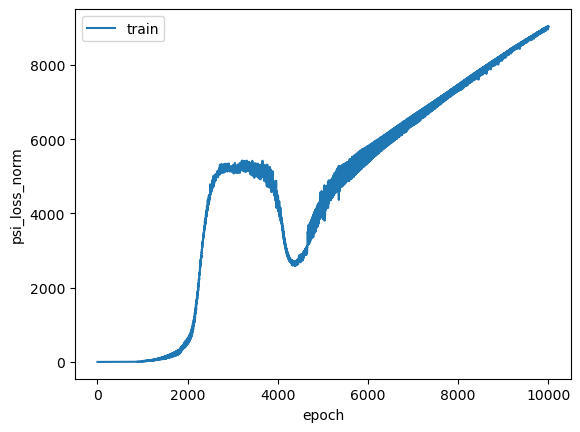

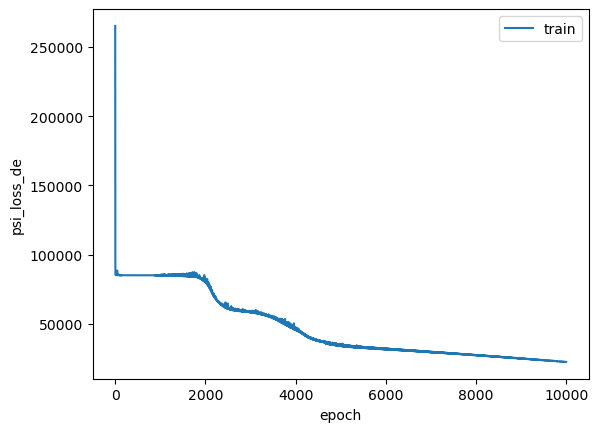

In [11]:
epoch_range = [i for i in range(num_epochs)]

for loss_idx in range(len(train_losses)):
    plt.close()
    plt.plot(epoch_range, mean_train_loss_vals[:, loss_idx], label="train")
    plt.xlabel("epoch")
    plt.ylabel(loss_names[loss_idx])
    plt.legend()
    plt.show()

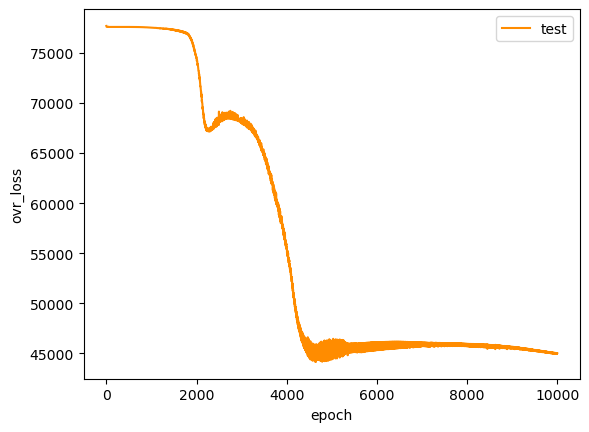

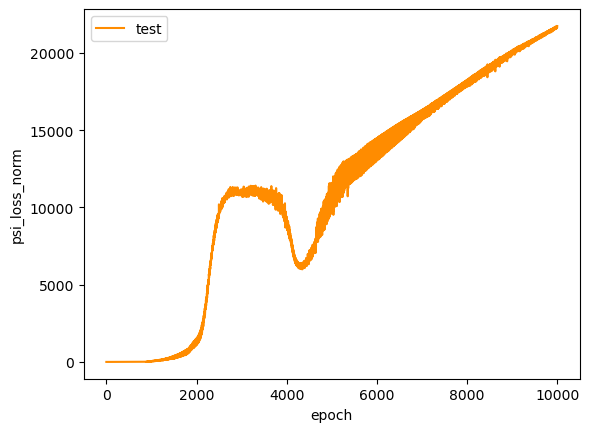

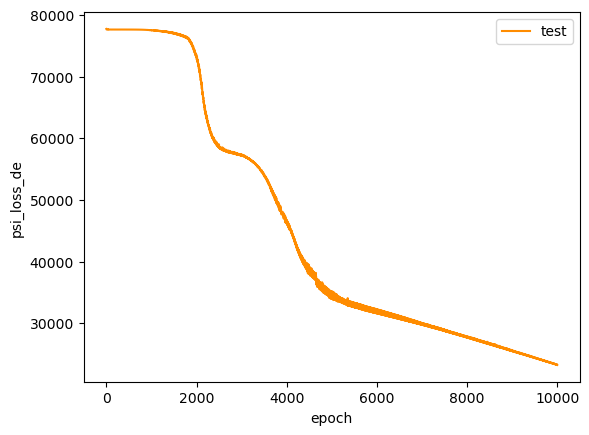

In [12]:
for loss_idx in range(len(train_losses)):
    plt.close()
    plt.plot(epoch_range, mean_test_loss_vals[:, loss_idx], label="test", color="darkorange")
    plt.xlabel("epoch")
    plt.ylabel(loss_names[loss_idx])
    plt.legend()
    plt.show()

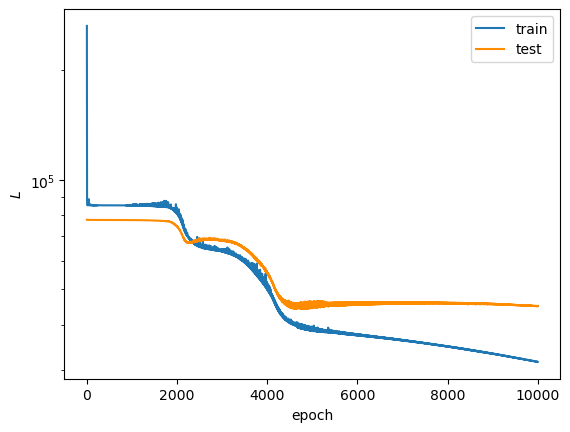

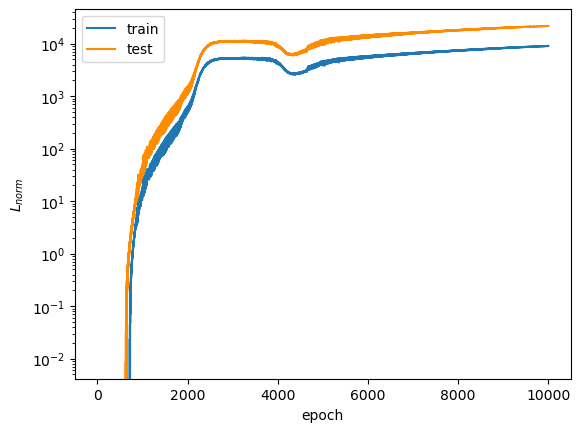

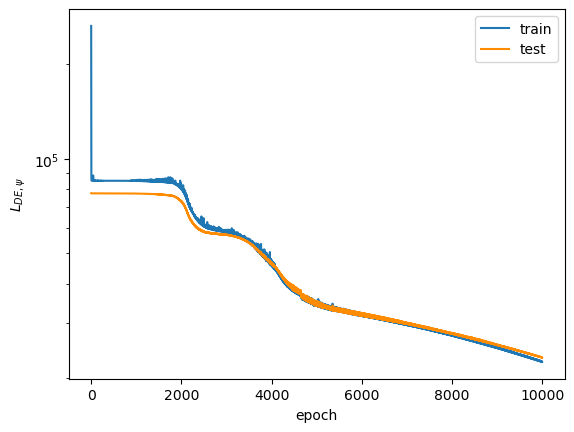

In [13]:
# same plots as above, but combined
epoch_range = [i for i in range(num_epochs)]
loss_names = ["$L$", r"$L_{norm}$", r"$L_{DE, \psi}$"]

for loss_idx in range(len(train_losses)):
    plt.close()
    plt.plot(epoch_range, mean_train_loss_vals[:, loss_idx], label="train")
    plt.plot(epoch_range, mean_test_loss_vals[:, loss_idx], color="darkorange", label="test")
    plt.xlabel("epoch")
    plt.ylabel(loss_names[loss_idx])
    plt.yscale("log")
    plt.legend()
    plt.show()

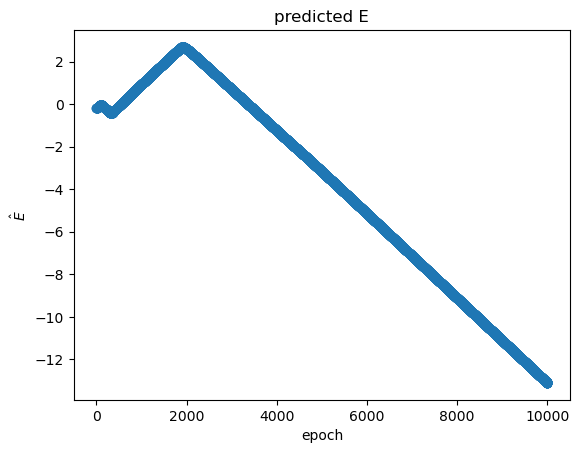

In [14]:
plt.close()
plt.scatter(epoch_range, E_predictions)
plt.title("predicted E")
plt.xlabel("epoch")
plt.ylabel(r"$\hat{E}$")
plt.show()

In [15]:
save_model = False

if save_model:
    model_path = "models/psi_R_Y_v0.model"
    torch.save(psi_PINN.state_dict(), model_path)

## PINN solution plots

In [16]:
N = 2000  # num samples to generate (going beyond 3000 makes 3d viz lag a bit and is hard to see max probs)
spherical_data = gen_spherical_data(N, min_r, max_r, device)
cartesian_data = spherical_to_cartesian(spherical_data)

# copy detached tensors for calculations below
spherical_detached = spherical_data.detach().cpu().numpy().copy()
cartesian_detached = cartesian_data.detach().cpu().numpy().copy()

# calculate radial eqn. solution
R_10_vals = calc_R_10(spherical_detached)

# calculate angular eqn. solution
Y_00_vals = calc_Y_00(spherical_data)

# calculate 1s^1 wave function
psi_100_vals = calc_psi_100(R_10_vals, Y_00_vals)

# calculate probability densities for radial eqn. solution
radial_prob_densities = calc_radial_prob_density(spherical_detached, R_10_vals)

# calculate probability densities for wave function 
psi_prob_densities = calc_psi_prob_density(spherical_detached, psi_100_vals)

# get PINN predictions on test data
# split test data into r, theta, phi
pred_r = spherical_data[:, 0].reshape(-1, 1)
pred_theta = spherical_data[:, 1].reshape(-1, 1)
pred_phi = spherical_data[:, 2].reshape(-1, 1)

# get predictions
pred_psi, pred_R, pred_Y = psi_PINN.forward(pred_r, pred_theta, pred_phi)
pred_psi = pred_psi.detach().cpu().numpy().flatten()
pred_R = pred_R.detach().cpu().numpy().flatten()
pred_Y = pred_Y.detach().cpu().numpy().flatten()
pred_psi_prob_densities = calc_psi_prob_density(spherical_detached, pred_psi)

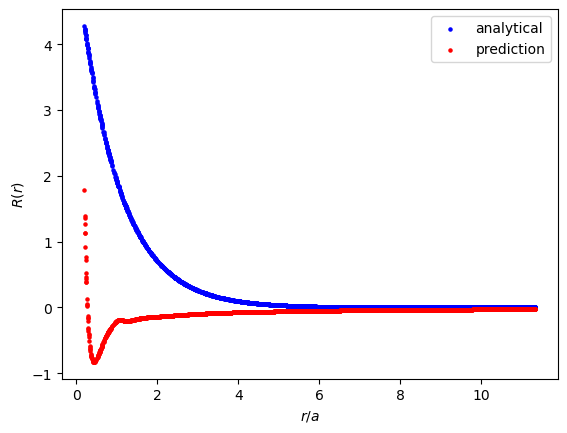

In [17]:
# R
plt.close()
plt.scatter(spherical_detached[:, 0] / bohr_radius, R_10_vals, label="analytical", color="b", s=5)
plt.scatter(spherical_detached[:, 0] / bohr_radius, pred_R, label="prediction", color="r", s=5)
plt.xlabel(r"$r/a$")
plt.ylabel(r"$R(r)$")
plt.legend()
plt.show()

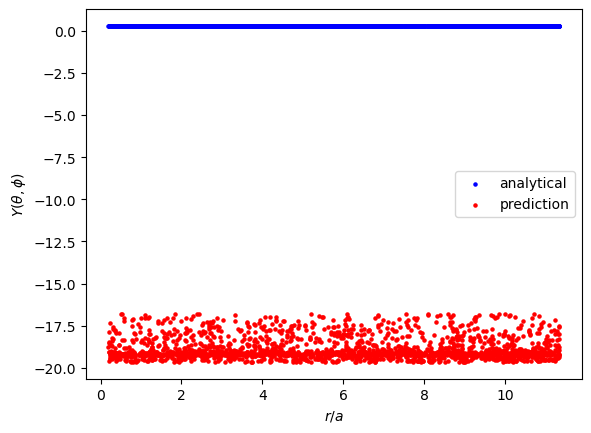

In [18]:
# Y
plt.close()
plt.scatter(spherical_detached[:, 0] / bohr_radius, Y_00_vals, label="analytical", color="b", s=5)
plt.scatter(spherical_detached[:, 0] / bohr_radius, pred_Y, label="prediction", color="r", s=5)
plt.xlabel(r"$r/a$")
plt.ylabel(r"$Y(\theta, \phi)$")
plt.legend()
plt.show()

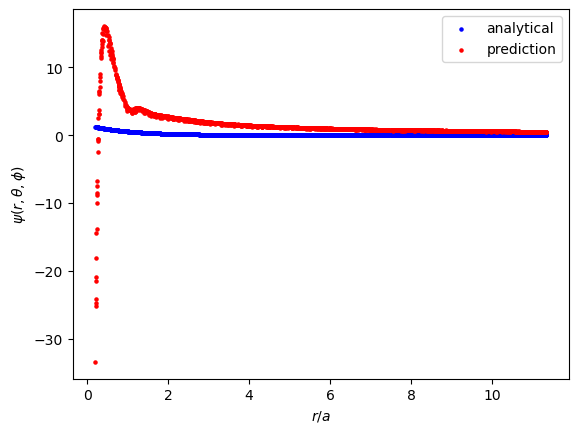

In [19]:
# psi
plt.close()
plt.scatter(spherical_detached[:, 0] / bohr_radius, psi_100_vals, label="analytical", color="b", s=5)
plt.scatter(spherical_detached[:, 0] / bohr_radius, pred_psi, label="prediction", color="r", s=5)
plt.xlabel(r"$r/a$")
plt.ylabel(r"$\psi(r, \theta, \phi)$")
plt.legend()
plt.show()

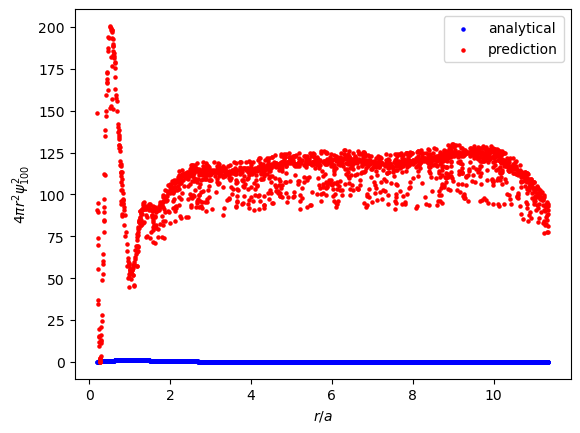

In [20]:
# psi prob densities
plt.close()
plt.scatter(spherical_detached[:, 0] / bohr_radius, psi_prob_densities, label="analytical", color="b", s=5)
plt.scatter(spherical_detached[:, 0] / bohr_radius, pred_psi_prob_densities, label="prediction", color="r", s=5)
plt.xlabel(r"$r/a$")
plt.ylabel(r"$4\pi$$r^2$$\psi_{100}^2$")
plt.legend()
plt.show()

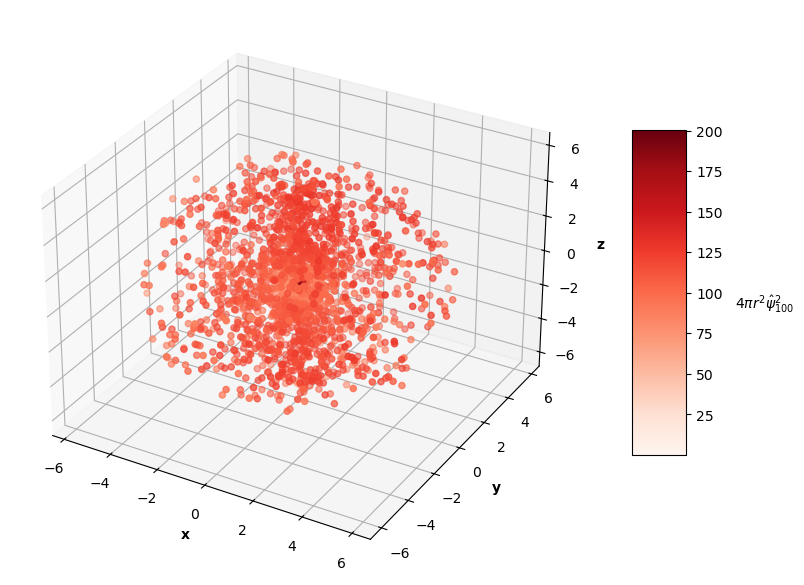

In [21]:
#%matplotlib notebook
# ^ run to make the plot interactive. seems buggy if you do this when running multiple cells,
# so just do this change manually and observe plots individually instead

# visualize 3D wave function probability densities 
fig = plt.figure(figsize=(8, 6), constrained_layout=True)
ax = fig.add_subplot(projection='3d')
scatter_ax = ax.scatter(cartesian_detached[:, 0], cartesian_detached[:, 1], cartesian_detached[:, 2], c=pred_psi_prob_densities, cmap="Reds")
colorbar = fig.colorbar(scatter_ax, shrink=0.55, aspect=6, pad=0.1)
colorbar.set_label(r"$4\pi$$r^2$$\hat{\psi}_{100}^2$", labelpad=30)
colorbar.ax.yaxis.label.set_rotation(0)
ax.set_xlabel("x", weight="bold")
ax.set_ylabel("y", weight="bold")
ax.set_zlabel("z", weight="bold")
plt.show()

In [22]:
max_PINN_prob_idx = np.argmax(pred_psi_prob_densities)
max_PINN_input = spherical_detached[max_PINN_prob_idx]
print(f"prediction with most likely wavefunction inputs:\nr = {max_PINN_input[0]}\nθ = {max_PINN_input[1]}\nϕ = {max_PINN_input[2]}")
print(f"r/a = {max_PINN_input[0] / bohr_radius}")
print()
print(f"predicted energy level:\nE_n = {psi_PINN.R_PINN.E.item()} eV")

prediction with most likely wavefunction inputs:
r = 0.27783891918793546
θ = 3.0425726559218726
ϕ = 4.432430152999362
r/a = 0.5252153481813524

predicted energy level:
E_n = -13.107950845239628 eV


## analytical solution plots

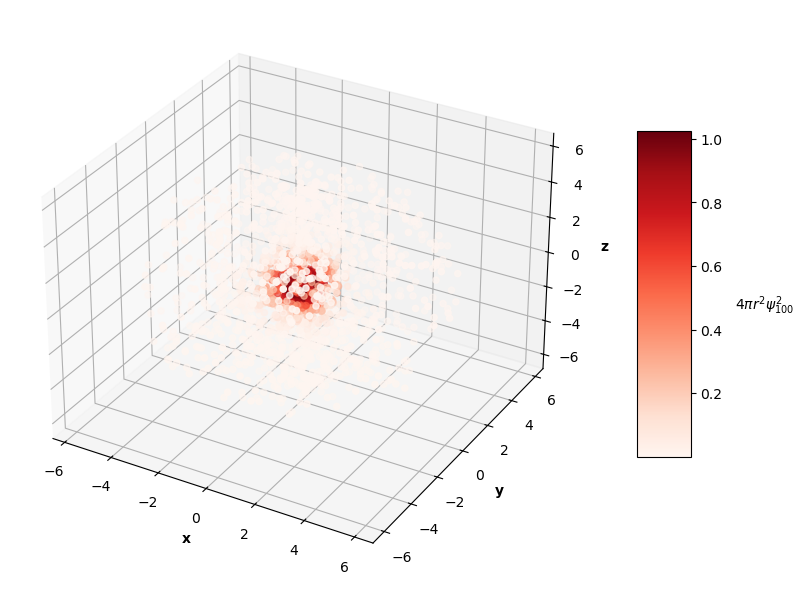

In [23]:
# visualize the wave function probability densities of all data points
fig = plt.figure(figsize=(8, 6), constrained_layout=True)
ax = fig.add_subplot(projection='3d')
scatter_ax = ax.scatter(cartesian_detached[:, 0], cartesian_detached[:, 1], cartesian_detached[:, 2], c=psi_prob_densities, cmap="Reds")
colorbar = fig.colorbar(scatter_ax, shrink=0.55, aspect=6, pad=0.1)
colorbar.set_label(r"$4\pi$$r^2$$\psi_{100}^2$", labelpad=30)
#colorbar.ax.yaxis.label.set_position((0, 0))
colorbar.ax.yaxis.label.set_rotation(0)
ax.set_xlabel("x", weight="bold")
ax.set_ylabel("y", weight="bold")
ax.set_zlabel("z", weight="bold")
plt.show()

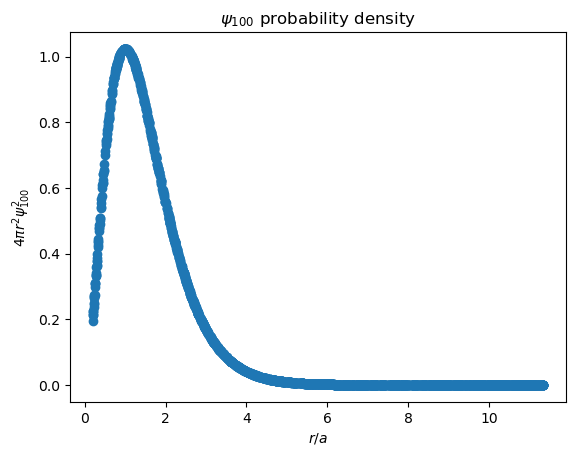

In [24]:
plt.close()  # need to run this to close interactive plots in other cells
plt.scatter(spherical_detached[:, 0] / bohr_radius, psi_prob_densities)
plt.title(r"$\psi_{100}$ probability density")
plt.xlabel(r"$r/a$")
plt.ylabel(r"$4\pi$$r^2$$\psi_{100}^2$")
plt.show()

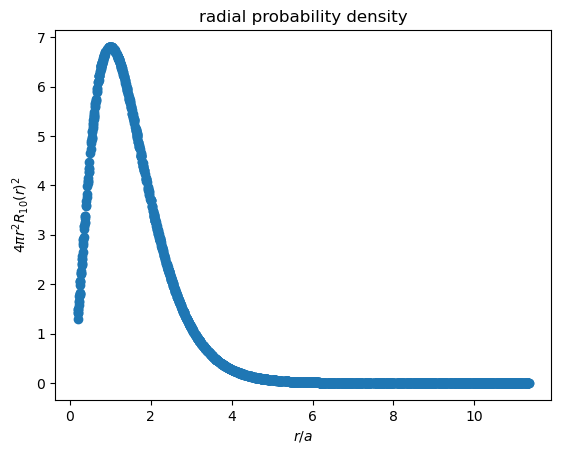

In [25]:
plt.close()  
plt.scatter(spherical_detached[:, 0] / bohr_radius, radial_prob_densities * bohr_radius)
plt.title("radial probability density")
plt.xlabel(r"$r/a$")
plt.ylabel(r"$4\pi$$r^2R_{10}(r)^2$")
plt.show()

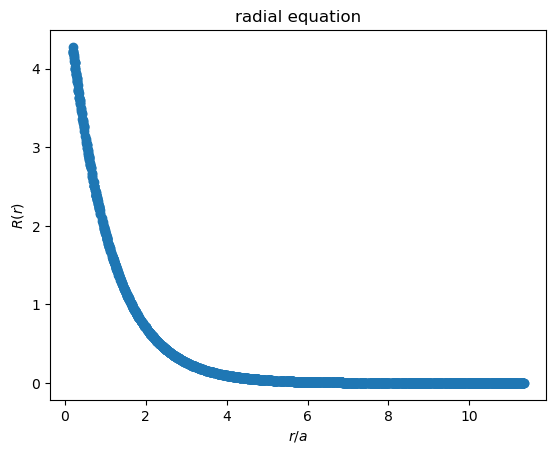

In [26]:
plt.close()
plt.scatter(spherical_detached[:, 0] / bohr_radius, R_10_vals)
plt.title("radial equation")
plt.xlabel(r"$r/a$")
plt.ylabel(r"$R(r)$")
plt.show()

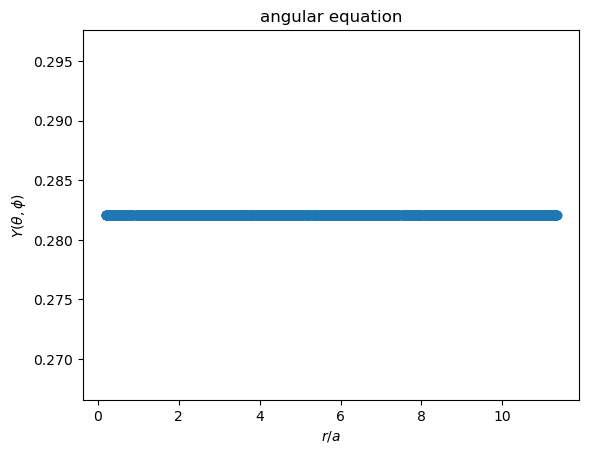

In [27]:
plt.close()
plt.scatter(spherical_detached[:, 0] / bohr_radius, Y_00_vals)
plt.title("angular equation")
plt.xlabel(r"$r/a$")
plt.ylabel(r"$Y(\theta,\phi$)")
plt.show()

In [28]:
E_n = calc_E(1)  # overkill
max_prob_idx = np.argmax(psi_prob_densities)
max_input = spherical_detached[max_prob_idx]
print(f"most likely wavefunction inputs:\nr = {max_input[0]}\nθ = {max_input[1]}\nϕ = {max_input[2]}")
print()
print(f"energy level:\nE_n = {E_n} eV")

most likely wavefunction inputs:
r = 0.5300804469917075
θ = 5.807446260465177
ϕ = 1.9697154310547738

energy level:
E_n = -13.6 eV
